In [2]:
!pip install cloudstorage

     |████████████████████████████████| 54 kB 2.0 MB/s 


In [2]:
!pip install google-cloud-storage==2.3.0

     |████████████████████████████████| 107 kB 5.3 MB/s 
     |████████████████████████████████| 76 kB 5.8 MB/s 
  Attempting uninstall: google-resumable-media
    Found existing installation: google-resumable-media 0.4.1
    Uninstalling google-resumable-media-0.4.1:
      Successfully uninstalled google-resumable-media-0.4.1
  Attempting uninstall: google-cloud-core
    Found existing installation: google-cloud-core 1.0.3
    Uninstalling google-cloud-core-1.0.3:
      Successfully uninstalled google-cloud-core-1.0.3
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 1.18.1
    Uninstalling google-cloud-storage-1.18.1:
      Successfully uninstalled google-cloud-storage-1.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-translate 1.5.0 requires google-cloud-core<2.0dev,>=1.0.0, but you have goog

In [23]:
#Version: 2.3.0
!pip3 show google-cloud-storage

Name: google-cloud-storage
Version: 1.18.1
Summary: Google Cloud Storage API client library
Home-page: https://github.com/GoogleCloudPlatform/google-cloud-python
Author: Google LLC
Author-email: googleapis-packages@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: google-cloud-core, google-resumable-media, google-auth
Required-by: firebase-admin, earthengine-api


In [24]:
import os
import cloudstorage as gcs
from google.cloud import storage


In [25]:
import os
import json
import time
import io

## External Libraries
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import Dataset, DataLoader
from skimage import io as skimgio
import matplotlib.pyplot as plt
import PIL.Image as Image

In [26]:
from google.colab import drive
drive.mount('/content/drive') #CHANGE THIS IF USE ON OWN
%cd /content/drive/MyDrive/Dan_Action_Recognition 
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Dan_Action_Recognition
deep-learning-action-rec-d5fce017335a.json  model_structure_plot.png
models					    training_data


### Connecting to Google Cloud Storage

In [27]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "deep-learning-action-rec-d5fce017335a.json"

In [28]:
BUCKET_NAME = "jhu_deep_learning_action_recognition_final_proj"

In [29]:
def test_read_file_blob(bucket_name, destination_blob_name):
    """Read a file from the bucket."""
 
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    #blob = bucket.blob(destination_blob_name)
 
    # read as string
    blob = storage_client.bucket(bucket_name).get_blob(destination_blob_name).download_as_string() #.28 seconds
    #blob = storage_client.bucket(bucket_name).get_blob(destination_blob_name).download_as_bytes() #0.3 seconds
    #print(blob)
    bytes_blob = io.BytesIO(blob)
    im = Image.open(bytes_blob)
    plt.imshow(im)

    transform = transforms.Compose([
      transforms.PILToTensor(),
      #transforms.Grayscale(num_output_channels=1), OPTIONAL PARAM
      transforms.Resize((64)),
      transforms.CenterCrop(64),
      transforms.Lambda(lambda x: x.float()),
      transforms.Normalize((0.5,), (0.5,)),
      transforms.Lambda(lambda x: x.long())
    ])
    print(transform(im).shape)
    print(transform(im)[0])
    plt.imshow(transform(im)[0])

    #gcs_file = gcs.open(file)
    #contents = gcs_file.read()
    #gcs_file.close()
    #print(blob.download_to_filename(blob.name))

    #frame = Image.open(blob.download_as_string())
    #print(frame)
    print(
        "File {} read successfully  from Bucket  {}.".format(
            destination_blob_name, bucket_name
        )
    )

torch.Size([3, 64, 64])
tensor([[425, 427, 437,  ..., 341, 337, 307],
        [421, 413, 453,  ..., 341, 349, 333],
        [439, 431, 441,  ..., 349, 349, 327],
        ...,
        [ 33,  37,  37,  ...,  43,  37,  41],
        [ 33,  31,  33,  ...,  57,  65,  79],
        [ 33,  29,  31,  ..., 289, 301, 293]])
File test/chew/Big_League_Chew_chew_h_nm_np1_fr_goo_2/image_00001.jpg read successfully  from Bucket  jhu_deep_learning_action_recognition_final_proj.
0.602766


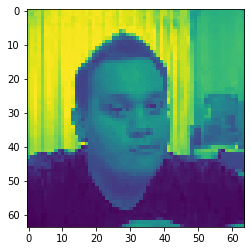

In [30]:
import time
start = time.time()
test_read_file_blob(BUCKET_NAME,"test/chew/Big_League_Chew_chew_h_nm_np1_fr_goo_2/image_00001.jpg")
print("%2f" % (time.time() - start))

### Loading Data

In [31]:
 #Define list of just 10 classes from list of 51. CUSTOM HYPERPARAM
#CLASSES_LIST = [ 'eat', 'walk', 'punch', 'sit', 'smile', 'climb', 'jump', 'kick','kiss', 'drink']
CLASSES_LIST_TEST = ['eat', 'walk', 'punch']


#USE THIS CLASS, more uniformly distributed
CLASSES_LIST = ['wave', 'brush-hair', 'catch', 'climb', 'eat', 'pick', 'pour', 'smile', 'sit-up' , 'kiss']

#classes_list_15 = [Wave, brush-hair, catch, climb, eat, pick, pour, smile, sit-up , kiss,     golf, sword, hit, shoot_ball, stand]


classes_dict = {class_name : idx for idx, class_name in enumerate(CLASSES_LIST)}

In [32]:
#Build index for dataloader 
#Needs to loop through entire dataset to build an index of all videos
#Takes 1-2 min to run with 10 different classes

def build_file_index(prefix_folder, classes_dict):
  video_list = set()
  storage_client = storage.Client()
  bucket = storage_client.bucket(BUCKET_NAME)

  for blob in bucket.list_blobs(prefix=prefix_folder + '/'):
    blob_path = blob.name
    blob_components = blob_path.split('/')
    # video_name = blob_components[-2:-1][0],
    class_name, video_path = blob_components[1],  '/'.join(blob_components[:-1])
    if video_path in video_list:
      continue

    if class_name in classes_dict:
      video_list.add(video_path)
  return list(video_list)

test_video_index = build_file_index('test', classes_dict)
valid_video_index = build_file_index('valid', classes_dict)
train_video_index = build_file_index('train', classes_dict)

In [33]:
def count_frames(prefix_folder, classes_dict):
  video_list = set()
  storage_client = storage.Client()
  bucket = storage_client.bucket(BUCKET_NAME)
  
  #Measure number of frames
  min_frame_count = 1000
  max_frame_count = 0
  frame_counts = []
  counter = 0
  
  for blob in bucket.list_blobs(prefix=prefix_folder + '/'):
    blob_path = blob.name
    blob_components = blob_path.split('/')
    class_name, video_path = blob_components[1],  '/'.join(blob_components[:-1])
    if video_path in video_list:
      counter += 1
      continue
    else:
      max_frame_count = max(max_frame_count, counter)
      if counter != 0:
        min_frame_count = min(min_frame_count, counter)
      frame_counts.append(counter)
      if counter > 300:
        print(video_path)
      counter = 1
      video_list.add(video_path)
  print(min_frame_count, max_frame_count)
  return sorted(frame_counts)


  
frame_counts = count_frames('valid', classes_dict)

valid/brush_hair/Brushing_my_Long_Hair__February_2009_brush_hair_u_nm_np1_ba_goo_2
valid/brush_hair/brush_my_hair_without_wearing_the_glasses_brush_hair_u_nm_np1_fr_goo_2
valid/climb/DM_Sportklettern_2006-_Finale_Herren_-_Markus_Hoppe_climb_f_cm_np1_ri_med_1
valid/kiss/TVs_Best_Kisses_Top_50_(30_to_21)_kiss_h_nm_np2_le_goo_4
valid/laugh/Skype_Laughter_Chain_Reaction_laugh_h_cm_np1_fr_goo_2
valid/pullup/100_pullups_pullup_f_nm_np1_fr_med_1
valid/ride_horse/ChelseaLately-Chelsea_ride_horse_f_cm_np1_le_med_5
valid/shoot_bow/Fellowship_7_shoot_bow_h_nm_np1_fr_goo_10
valid/shoot_bow/JuanReneSerranoSemifinal_shoot_bow_u_cm_np1_fr_goo_6
valid/shoot_bow/ParkKyungMo_shoot_bow_f_cm_np2_fr_med_0
valid/swing_baseball/Faith_Rewarded_swing_baseball_f_cm_np1_ri_bad_37
valid/wave/50_FIRST_DATES_wave_u_cm_np1_fr_goo_30
22 532


In [14]:
len(test_video_index), len(valid_video_index), len(train_video_index), len(frame_counts)

(88, 88, 662, 700)

In [34]:
print(frame_counts)

[0, 22, 22, 22, 24, 25, 26, 29, 29, 31, 31, 31, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 44, 44, 44, 44, 44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 51, 51, 51, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 56, 56, 57, 57, 57, 58, 58, 58, 58, 58, 58, 59, 59, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 63, 63, 64, 64, 64, 64, 65, 65, 65, 65, 65, 66, 66, 66, 67, 67, 67, 67, 68, 68, 69, 69, 69, 71, 71, 71, 71, 71, 72, 72, 72, 

(array([169., 368., 100.,  22.,  18.,  14.,   5.,   2.,   0.,   2.]),
 array([  0. ,  53.2, 106.4, 159.6, 212.8, 266. , 319.2, 372.4, 425.6,
        478.8, 532. ]),
 <a list of 10 Patch objects>)

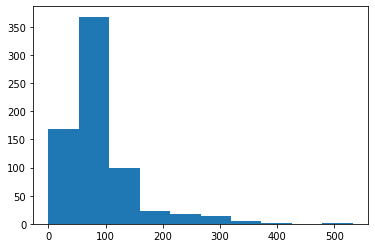

In [35]:
plt.hist(frame_counts)

### Attempt parallization

In [36]:
#Worker Manager for parallel google cloud dataset building request
import queue
from threading import Thread, Lock
from queue import Empty, Queue
import traceback

class WorkerManager:
    '''
    Class that handles multithreading
    '''
    
    class WorkerMangerException(Exception):
        pass

    def __init__(self, target_func, worker_num=20) -> None:
        self._threads = []
        self._worker_num = worker_num
        self._target_function = target_func
        self._stop = True
        self._queue = Queue(worker_num * 5)
        self._lock = Lock()
    
    def start(self):
        '''
        Initialize worker manager
        '''
        with self._lock:
            if not self._stop:
                raise self.WorkerMangerException("Worker Manager has already started")

            self._stop = False
            for idx in range(self._worker_num):
                thread = Thread(target=self.assign_thread_to_task, name="%d thread" % (idx))
                thread.setDaemon(True)
                self._threads.append(thread)
                thread.start()
            
        return
    
    def put(self, record, idx):
        '''
        Add record to queue
        '''
        if self._stop:
            raise self.WorkerMangerException("Worker Manger has not been started")
        self._queue.put((record, idx))
    
    def stop(self):
        '''
        Stops the worker manager, joins remaining threads
        '''
        with self._lock:
            if self._stop:
                return
            self._stop = True
            
        for thread in self._threads:
            thread.join()
    

    def assign_thread_to_task(self):
        '''
        Pull from Queue and assign each thread to a task if workers are available
        '''
        def handle_stop():
            if self._stop:
                pass#print("queue is empty")
        while not self._stop:
            self._lock.acquire()
            while not self._queue.empty():
                self._lock.release()
                try:
                    self._lock.acquire()
                    record, idx = self._queue.get()
                    self._lock.release()
                    self._target_function(record, idx)
                except Empty:
                    print('empty queue at this time')
                    handle_stop()
                except Exception as e:
                    traceback.print_exc()
                    print("%s exception occured for idx: %s, record: %s" % (e, idx, record))
                self._lock.acquire()

            self._lock.release()
        handle_stop()



In [37]:
#Cell to test if threading/queueing works (it does)
#TEST CELL NO NEED TO RUN
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)

import time
start = time.time()
vid_list = []

lock = Lock()


test_transform = transforms.Compose([
      transforms.PILToTensor(),
      transforms.Grayscale(num_output_channels=1),
      transforms.Resize((64)),
      transforms.CenterCrop(64),
      transforms.Lambda(lambda x: x.float()),
      transforms.Normalize((0.5,), (0.5,)),
      transforms.Lambda(lambda x: x.long())
    ])

def multi_thread_handler(blob, idx):
    str_blob = blob.download_as_string()
    bytes_str = io.BytesIO(str_blob)
    img = Image.open(bytes_str)
    img = test_transform(img)
    #print(price, url)
    with lock:
        vid_list.append((idx, img))

worker_manager = WorkerManager(multi_thread_handler, 15)
worker_manager.start()

#Looping through 75 frames takes about 45 seconds w/ no para
for idx, blob in enumerate(bucket.list_blobs(prefix='test/chew/Big_League_Chew_chew_h_nm_np1_fr_goo_2' + '/')):
  worker_manager.put(blob, idx)


print('End of worker manager')
worker_manager.stop() 

vid_list.sort(key = lambda x: x[0])
print("%2f" % (time.time() - start))

End of worker manager
1.421505


Drop after 100 frames

In [38]:
## Image DataSet Item

class VideoDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 dir,
                 max_frame_count,
                 video_path_list,
                 classes_dict,
                 transforms=None,
                 ):
        """        
        Args:
            dir (list): name of 'root' directory, 'train', 'valid' or 'test'
            max_frame_count (int): max frames in a video
            video_path_list (list): name of all video paths
            classes_dict (dict): Lookup dict of class names to index
            transforms (list or None): Image transformations to apply upon loading.
        """
        
        self.transform = transforms
        self.classes_dict = classes_dict
        self.video_path_list = video_path_list
        self.dir = dir + '/'
        storage_client = storage.Client()
        self.max_frame_count = max_frame_count
        self.bucket = storage_client.bucket(BUCKET_NAME)
        self.lock = Lock()

    def __len__(self):
        """
        Get length of the dataset
        """
        return len(self.video_path_list)


    def _get_video_item_old(self, idx):
      '''
      Non parrallel way of getting video items
      '''
      video_path = self.video_path_list[idx]
      label = self.classes_dict[video_path.split('/')[1]]
      #print(video_path, label, video_path.split('/')[1], "HI")
      video_list = []

      for idx, blob in enumerate(self.bucket.list_blobs(prefix=video_path + '/')):
        if idx >= self.max_frame_count:
          break
        str_blob = blob.download_as_string()
        bytes_str = io.BytesIO(str_blob)
        img = Image.open(bytes_str)

        if self.transform:
            img = self.transform(img)
        video_list.append(img)
      
      if self.max_frame_count > len(video_list):
        zero_padding = [torch.zeros(1, 64, 64).long() for _ in range(self.max_frame_count - len(video_list))]
        video_list += zero_padding
      
      #Redo for parrallel purposes
      video = torch.cat(tuple(video_list), 0)
      return video, label
    
    #Potential TODO: Add frame offset to start at center
    def _get_video_item(self, idx):
      '''
      Parrallel way of getting video items
      '''
      video_path = self.video_path_list[idx]
      label = self.classes_dict[video_path.split('/')[1]]
      #print(video_path, label, video_path.split('/')[1], "HI")
      video_list = []

      def multi_thread_handler(blob, idx):
        str_blob = blob.download_as_string()
        bytes_str = io.BytesIO(str_blob)
        img = Image.open(bytes_str)
        
        #print(price, url)
        with self.lock:
            img = self.transform(img)
            video_list.append((idx, img))

      worker_manager = WorkerManager(multi_thread_handler, 15)
      worker_manager.start()

      bucket = self.bucket
      for idx, blob in enumerate(bucket.list_blobs(prefix=video_path + '/')):
        if idx < self.max_frame_count:
          worker_manager.put(blob, idx)

      #Get just the video frames
      worker_manager.stop() 
      video_list.sort(key = lambda x: x[0])
      video_list_clean = [x[1] for x in video_list]
      
      #Pad rest of video
      if self.max_frame_count > len(video_list_clean):
        zero_padding = [torch.zeros(3, 64, 64).long() for _ in range(self.max_frame_count - len(video_list_clean))]
        video_list_clean += zero_padding
      
      #Redo for parrallel purposes
      video = torch.stack(video_list_clean, 0)
      return video, label


    def __getitem__(self,
                    idx):
        """
        Gets the image and target
        """
        img, target = self._get_video_item(idx)
        return img, target

In [39]:
#HYPER PARAM
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32 
MAX_FRAME_COUNT = 75 
'''
dir,
max_frame_count,
video_path_list,
classes_dict
'''

##Now create dataloader
img_transform = transforms.Compose([
      transforms.PILToTensor(),
      #transforms.Grayscale(num_output_channels=1),
      transforms.Resize((64)),
      transforms.CenterCrop(64),
      transforms.Lambda(lambda x: x.float()),
      transforms.Normalize((0.5,), (0.5,)),
      #transforms.Lambda(lambda x: x.long())
    ])

train_dataset=VideoDataset(dir="train", max_frame_count=MAX_FRAME_COUNT, video_path_list=train_video_index, classes_dict=classes_dict,  transforms=img_transform)
validation_dataset=VideoDataset(dir="valid", max_frame_count=MAX_FRAME_COUNT, video_path_list=valid_video_index, classes_dict=classes_dict, transforms=img_transform)
test_dataset=VideoDataset(dir='test', max_frame_count=MAX_FRAME_COUNT, video_path_list=test_video_index, classes_dict=classes_dict, transforms=img_transform)

train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2, prefetch_factor=2 ) ##
validation_dataloader = DataLoader(validation_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2, prefetch_factor=2) #, 
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)


In [20]:
#Batch size of 32 takes 6 min (75 frames), 5 min 11 seconds (60 frames)
#Batch size 8 was like 72 seconds
import time
start = time.time()
total_hit = 0
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for i, (x,y) in enumerate(test_dataloader):
  x = x.to(device)
  y = y.to(device)
  print(x.device, x.shape)
  print("%2f" % (time.time() - start))
  print(i, x.shape, y, len(y))
  total_hit += len(y)
  break



cuda:0 torch.Size([1, 75, 3, 64, 64])
13.795006
0 torch.Size([1, 75, 3, 64, 64]) tensor([6], device='cuda:0') 1


In [21]:
classes_dict, total_hit

({'brush-hair': 1,
  'catch': 2,
  'climb': 3,
  'eat': 4,
  'kiss': 9,
  'pick': 5,
  'pour': 6,
  'sit-up': 8,
  'smile': 7,
  'wave': 0},
 1)

### Defining ConvLSTM Model

In [40]:
#Create a ConvLSTM Model, use VGG16 for transfer learning
from torchvision.models import vgg16

class ConvLSTM(nn.Module):
    def __init__(self, model_fn, model_name, input_size, fc_size, lstm_layers, hidden_size, num_classes):
        super(ConvLSTM, self).__init__()

        
        '''self.conv1 = nn.Conv2d(input_size, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.bn_conv = nn.BatchNorm2d(64)
        self,max_pool = nn.MaxPool2d(2)
        self.avg_pool = nn.AvgPool2d(2)
        self.Linear_One = nn.Linear(in_features, 256)
        self.bn_two = nn.BatchNorm1d(256)
        self.output_layer = nn.Linear(256, num_classes)'''

        ##activations:
        self.relu = nn.ReLU()
        
        if model_name == 'vgg_16':
          original_model = model_fn(pretrained=True)
          self.conv_features = nn.Sequential(*list(original_model.children())[:-1])
          for i, param in enumerate(self.conv_features.parameters()):
            if i < 20:
              param.requires_grad = False
          self.fc_prelstm = nn.Sequential(nn.Linear(25088, fc_size), nn.Dropout())
          self.lstm = nn.LSTM(input_size = fc_size,
              hidden_size = hidden_size,
              num_layers = lstm_layers,
              batch_first = True)
          
          self.output_layer = nn.Linear(hidden_size, num_classes)
          self.modelName = 'vgg16_lstm'
        else:
          #TODO: Support Basic ConvLSTM here
          self.modelName = 'Basic'
          raise Exception("This architecture has not been supported yet")
    

    def _build_basic_conv():
      '''
      Model that builds basic ConvNet
      '''
      pass
                
    def forward(self, input_data):
        '''
        Forward data through the lstm
        '''
        length = len(input_data)
        feature_store = torch.zeros(length, input_data[0].size(0), self.lstm.input_size).cuda()

        for i in range(input_data[0].size(0)):
          feature_at_i = self.conv_features(input_data[:, i, :, :])
          #feature_at_i = self.conv_features(input_data[i])
          
          feature_at_i= feature_at_i.view(feature_at_i.size(0), -1)
          feature_at_i = self.fc_prelstm(feature_at_i)
          feature_store[:, i, :] = feature_at_i

        outputs, hidden = self.lstm(feature_store, None)
        outputs = self.output_layer(outputs)

        return outputs

### Training Loop

In [41]:
###Define Plot Function
def plot_loss_charts(train_loss_store, val_loss_store):
  '''
  Plots loss charts over course of training
  '''

  ## Plotting epoch-wise test loss curve:
  plt.plot(train_loss_store, '-o', label = 'train_loss', color = 'blue')
  plt.plot(val_loss_store, '-o', label = 'validation_loss', color = 'orange')
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss At each epoch of training')
  plt.legend()
  plt.show()

def plot_acc_charts(train_acc_score, val_acc_score):
  '''
  Plot Accuracy
  '''
  plt.plot(train_acc_score, '-o', label = 'train_accuracy', color = 'blue')
  plt.plot(val_acc_score, '-o', label = 'validation_accuracy', color = 'orange')
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy At each epoch of training')
  plt.legend()
  plt.show()

In [42]:
##Define Loss and Accuracy Eval Function
def eval_acc_loss(model, loader, device, loss_metric, is_train = False, verbose = 1):
    '''
    Evaluate Function for CNN training
    Slightly different than eval function from part 1
    '''
    correct, total, loss_sum = 0, 0, 0
    
    eval_type = "Train" if is_train else "Validation"
    for X, labels in loader:
        outputs, predicted, calculated_loss = None, None, None
        X, labels = X.to(device), labels.to(device)

        outputs = model(X)
        outputs = outputs[:, -1, :]
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()
        calculated_loss = loss_metric(outputs,labels).item()
        loss_sum += calculated_loss
        
    outputs, predicted, calculated_loss = None, None, None
    if verbose:
        print('%s accuracy: %f %%' % (eval_type, 100.0 * correct / total))
        print('%s loss: %f' % (eval_type, loss_sum / total))
    print
    return 100.0 * correct / total, loss_sum/ total

In [43]:
#Code to save a model and epoch stats
import json
def handle_model_save(val_acc_store, val_loss_store, train_loss_store, train_acc_store,
                      base_path, model_name, epoch_num, model, optimizer):
  '''
  Function for saving models and training data
  '''
  save_dict = {
      'val_acc_store': val_acc_store,
      'val_loss_store': val_loss_store,
      'train_loss_store': train_loss_store,
      'train_acc_store': train_acc_store,
      'epoch': epoch_num,
  }
  traing_info_path = "%s/training_data/%s_%s.json" % (base_path, model_name, epoch_num)
  with open(traing_info_path, 'w') as f:
    json.dump(save_dict, f)

  MODEL_PATH = "%s/models/%s_%s" % (base_path, model_name, epoch_num)
  torch.save({
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              }, MODEL_PATH)


def load_train_data(traing_info_path):
  with open(traing_info_path) as json_file:
    data = json.load(json_file)
  
  return data['val_acc_store'], data['val_loss_store'], data['train_loss_store'], data['train_acc_store'], int(data['epoch'])
  

In [44]:
#Note, train 20 - 25 epochs
def train(model,
          optimizer,
          loss_metric,
          lr,
          train_dataloader,
          valid_dataloader,
          device,
          epochs=5,
          stopping_threshold=3,
          saving_per_epoch=10,
          base_save_path="",
          model_name="",
          load_train_hist_path=None,
          **kwargs):
    """
    For each epoch, loop through batch,
    compute forward and backward passes, apply gradient updates
    Evaluate results and output
    """

    #defining batch train loss recording arrays for later visualization/plotting:
    #If data already exists, that means the model was preloaded and training should
    #resume from where it was interupted
    if load_train_hist_path is not None:
      val_acc_store, val_loss_store, train_loss_store, train_acc_store, start_epoch =load_train_data(load_train_hist_path)
    else:
      train_loss_store, train_acc_store = [], []
      val_loss_store, val_acc_store, = [], []
      start_epoch = 0

    #Declare variables for early stopping
    last_val_loss, stop_tracker = 100, 0

    #training loop:
    print("Starting Training")
    for epoch in range(start_epoch, epochs):
      time1 = time.time() #timekeeping
      outputs, loss = None, None

      model.train()
      
      correct_train, total, loss_sum = 0, 0, 0
      for i, (x,y) in enumerate(train_dataloader):
        
        # Print device human readable names
        torch.cuda.get_device_name()

        x = x.to(device)
        y = y.to(device)

        #loss calculation and gradient update:

        if i > 0 or epoch > 0:
          optimizer.zero_grad()
        outputs = model.forward(x)

        outputs = outputs[:, -1, :]
        loss = loss_metric(outputs,y)
        loss.backward()
                      
        ##performing update:
        optimizer.step()

        #Update Loss Info
        loss_sum += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += y.size(0)
        correct_train += (predicted == y).sum().item()

      print("Epoch",epoch+1,':')

      
      model.eval()
      with torch.no_grad():

        #Print Train Info
        print('%s accuracy: %f %%' % ("Train", 100.0 * correct_train / total))
        print('%s loss: %f' % ("Train", loss_sum / total))
        print
        
        train_acc, train_loss = 100.0 * correct_train / total, loss_sum/ total
        val_acc, val_loss = eval_acc_loss(model, valid_dataloader, device, loss_metric, is_train = False)

        val_acc_store.append(val_acc)
        val_loss_store.append(val_loss)

        train_loss_store.append(train_loss)
        train_acc_store.append(train_acc)

      time2 = time.time() #timekeeping
      #if show_progress:
      print('Elapsed time for epoch:',time2 - time1,'s')
      print('ETA of completion:',(time2 - time1)*(epochs - epoch - 1)/60,'minutes')
      

      #Handle model/stat saving
      if (epoch + 1) % saving_per_epoch == 0:
        handle_model_save(val_acc_store, val_loss_store, train_loss_store, train_acc_store,
                          base_save_path, model_name, epoch + 1, model, optimizer)
        print("Model Copy Saved")
      print()

      #Handle early stopping logic
      if val_loss >= last_val_loss:
            stop_tracker += 1
            if stop_tracker >= stopping_threshold:
                print('Early Stopping triggered, Convergence has occured')
                plot_loss_charts(train_loss_store, val_loss_store)
                plot_acc_charts(train_acc_store, val_acc_store)
                handle_model_save(val_acc_store, val_loss_store, train_loss_store, train_acc_store,
                  base_save_path, model_name, epoch + 1, model, optimizer)
                print("Model Copy Saved")

                return train_loss_store, val_acc_store
      else:
          stop_tracker = 0
      last_val_loss = val_loss


    plot_loss_charts(train_loss_store, val_loss_store)
    plot_acc_charts(train_acc_store, val_acc_store)
    return train_loss_store, val_acc_store

### Running loop

In [45]:
MODEL_LOAD= True #Set to True if using a model that has some training
MODEL_PATH_BASE = "/content/drive/MyDrive/Dan_Action_Recognition"
MODEL_NAME, LAST_EPOCH = "vgg16convlstm", 34

#Create the Model (90)
conv_lstm_model = ConvLSTM(vgg16, 'vgg_16', input_size=3, fc_size=1024, lstm_layers=2, hidden_size=512, num_classes=10)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
conv_lstm_model = conv_lstm_model.to(device)

#optimizer = torch.optim.SGD(conv_lstm_model.parameters(), lr = 0.01)
optimizer = torch.optim.Adam([{'params': conv_lstm_model.conv_features.parameters()},
	                             {'params': conv_lstm_model.fc_prelstm.parameters()},
								{'params': conv_lstm_model.lstm.parameters()},
								{'params': conv_lstm_model.output_layer.parameters()}],
								lr=0.0001) #try 0.0001 Looks like this is ideal combo for params

if MODEL_LOAD:
	model_path = "%s/models/%s_%s" % (MODEL_PATH_BASE, MODEL_NAME, str(LAST_EPOCH))
	model_checkpoint = torch.load(model_path)
	conv_lstm_model.load_state_dict(model_checkpoint['model_state_dict'])
	optimizer.load_state_dict(model_checkpoint['optimizer_state_dict'])

#optimizer = torch.optim.SGD(conv_lstm_model.parameters(), lr=0.001, momentum=0.9)
loss_metric = nn.CrossEntropyLoss()


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [28]:
if MODEL_LOAD: #train from last x epoch
  LOAD_TRAIN_PATH = "%s/training_data/%s_%s.json" % (MODEL_PATH_BASE, MODEL_NAME, str(LAST_EPOCH))
  train(conv_lstm_model, optimizer, loss_metric, 0.0001, 
          train_dataloader, validation_dataloader,
          device, epochs=100, 
          stopping_threshold=3, saving_per_epoch=5,
          base_save_path=MODEL_PATH_BASE,
          model_name=MODEL_NAME,
          load_train_hist_path=LOAD_TRAIN_PATH
        )
else: #train from 1st epoch
  train(conv_lstm_model, optimizer, loss_metric, 0.0001, 
          train_dataloader, validation_dataloader,
          device, epochs=100, 
          stopping_threshold=3, saving_per_epoch=5,
          base_save_path=MODEL_PATH_BASE,
          model_name=MODEL_NAME
        )

Starting Training
Epoch 21 :
Train accuracy: 85.498489 %
Train loss: 0.013443
Validation accuracy: 65.909091 %
Validation loss: 0.037783
Elapsed time for epoch: 268.51230788230896 s
ETA of completion: 353.5412053783735 minutes

Epoch 22 :
Train accuracy: 88.821752 %
Train loss: 0.011216
Validation accuracy: 65.909091 %
Validation loss: 0.041753
Elapsed time for epoch: 269.3605146408081 s
ETA of completion: 350.16866903305055 minutes

Epoch 23 :
Train accuracy: 87.009063 %
Train loss: 0.012581
Validation accuracy: 63.636364 %
Validation loss: 0.040108
Elapsed time for epoch: 238.31399822235107 s
ETA of completion: 305.83629771868385 minutes

Epoch 24 :
Train accuracy: 88.066465 %
Train loss: 0.012057
Validation accuracy: 67.045455 %
Validation loss: 0.035468
Elapsed time for epoch: 253.61318826675415 s
ETA of completion: 321.24337180455524 minutes

Epoch 25 :
Train accuracy: 88.670695 %
Train loss: 0.010564
Validation accuracy: 64.772727 %
Validation loss: 0.034306
Elapsed time for epoc

KeyboardInterrupt: ignored

In [31]:
#Evaluate test score
test_acc, test_loss = eval_acc_loss(conv_lstm_model, test_dataloader, device, loss_metric, is_train = False)
test_acc

Test accuracy: 69.318182 %
Test loss: 1.216619


69.31818181818181

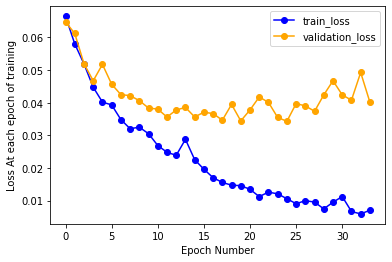

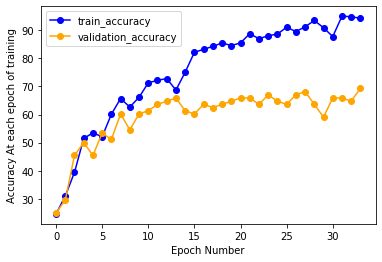

In [22]:
### Load and Plot Curves

LOAD_TRAIN_PATH = "%s/training_data/%s_%s.json" % (MODEL_PATH_BASE, MODEL_NAME, str(34))
val_accs, val_losses, train_losses, train_accs, _ =  load_train_data(LOAD_TRAIN_PATH)

plot_loss_charts(train_losses, val_losses)
plot_acc_charts(train_accs, val_accs)


In [49]:
test_acc, test_loss = eval_acc_loss(conv_lstm_model, test_dataloader, device, loss_metric, is_train = False)
test_acc

Validation accuracy: 68.181818 %
Validation loss: 1.273292


68.18181818181819